In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from datetime import datetime, timedelta
from shutil import copyfile

In [16]:
base = 'D://Serhat/data/glaucoma_progression'
#csv_paths = [base+'/csv_files/RAW_DATASET_1.csv', base+'/csv_files/RAW_DATASET_2.csv']
vf_path = base+'/csv_files/ALL_VF_CSV.csv'
img_paths = [base+'/CROPPED', base+'/CROPPED_NEW', base+'/CROPPED_LAST_MISSING']

In [17]:
vf = pd.read_csv(vf_path)

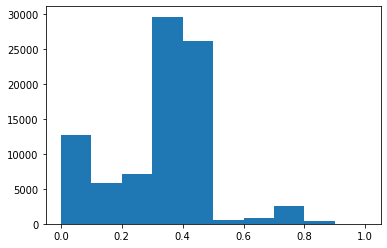

In [13]:
plt.hist(np.array((vf[['L_'+str(i) for i in range(1,69)]]+37)/87).flatten())
plt.show()

In [18]:
count=0
for img_path in img_paths:
    for i in os.listdir(img_path):
        count += len(os.listdir(img_path+'/'+i))
count  # appears to be some missing images...

1158

So there's at most 150 more images for me to work with... not a lot really
61 of those are going to fail due to missing zs downstream

due to time constraints I'm going to move forward and ask Vahid later, just pull everything that I can 

just do a 95/5 split of what I have for now and I can add more images later


In [19]:
def check_dates(path, date):
    # go through and check if there are any visit dates in the folder within 6 months of visit_date[i]
    
    date = date.split(' ')[0]  # handles the case if the date include the time
    if '-' in date:
        date = date.replace('-', '_')  # another exception, sometimes Y-m-d!
    if os.path.isdir(path):
        month_deltas, months = [], []
        for subpath in os.listdir(path):
            try:
                month_deltas.append((datetime.strptime(subpath, "%Y_%m_%d")-
                                     datetime.strptime(date, "%Y_%m_%d")).days/30.42)  # avg n days/month
                months.append(subpath)
            except:
                try:
                    month_deltas.append((datetime.strptime(subpath, "%Y_%d_%m")-
                                         datetime.strptime(date, "%Y_%m_%d")).days/30.42)  # avg n days/month
                    months.append(subpath)
                except:
                    print('date_failed')
                    pass

        if len(month_deltas):
            closest_visit = months[month_deltas.index(np.min(month_deltas))]
            if np.min(np.abs(month_deltas))<6.1:
                return closest_visit

In [20]:
def get_images_2(pat_id, visit_date, eye):
    eye_dict = {'RE': '_OD', 'LE': '_OS', 'OS': '_OS', 'OD': '_OD'}
    dir_name = False
    for img_path in img_paths:
        if os.path.isdir(img_path+'/'+pat_id+eye_dict[eye]+'/'+visit_date):
            dir_name = img_path+'/'+pat_id+eye_dict[eye]+'/'+visit_date
            break
        elif os.path.isdir(img_path+'/'+pat_id+'_'+eye+'/'+visit_date):
            dir_name = img_path+'/'+pat_id+'_'+eye+'/'+visit_date
            break
        else:  # most likely date is wrong
            possible_paths = [img_path+'/'+pat_id+eye_dict[eye], img_path+'/'+pat_id+'_'+eye]
            for path in possible_paths:
                if os.path.isdir(path):
                    closest_date = check_dates(path, visit_date)
                    if closest_date:
                        if os.path.isdir(path+'/'+closest_date):
                            print('Found date within 6 months!')
                            dir_name = path+'/'+closest_date
                            break
    if dir_name:
        # images are rgba but r=g=b=a, so just take r channel
        images = np.array([np.array(Image.open(dir_name+'/'+im))[:,:,0] for im in os.listdir(dir_name)])  # its rgba but r=g=b
        return images, img_path+'/'+pat_id+eye_dict[eye]+'/'  
    else:
        return False, False

In [21]:
vf['Used'] = np.zeros(len(vf.index))  # want to keep good track of which ones I actually find data for 

In [25]:
# load all the images (only 1.3gbs,  not huge at all)
# figure out maximum size
imgs = {}
lefties = []
#used_dates = {vf['PAT_ID'][i]+vf['EYE'][i]:[] for i in vf.index}
bad_ixs = []
for i in vf.index:
    img, path = get_images_2(vf['PAT_ID'][i], vf['VISIT_DATE'][i], vf['EYE'][i])
    if path:
        if img.shape[0] == 61:
            if 'OS' in vf['EYE'][i] or 'LE' in vf['EYE'][i]:
                lefties.append(len(imgs))
            imgs[i] = img
            #imgs[i] = i
            vf['Used'][i] = 1
        else:
            print(img.shape[0], '<-- insufficient zs :/')
            pass
    else:
        bad_ixs.append(i)
        print(len(bad_ixs))

C:\Users\fabien\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Found date within 6 months!
Found date within 6 months!
1
Found date within 6 months!
Found date within 6 months!


IndexError: too many indices for array

In [26]:
vf['Used'].sum(), len(imgs)  # should be 1126

(24.0, 24)

In [16]:
vf_used = vf.loc[vf['Used']==1]
vf_used.to_csv('vf_used_062620.csv')

In [27]:
hs, ws = [], []
for i in imgs.keys():
    for j in imgs[i]:
        hs.append(j.shape[0])
        ws.append(j.shape[1])

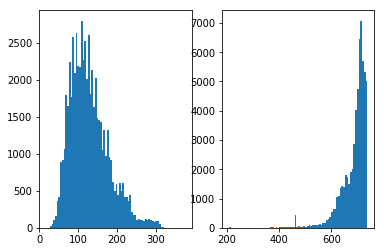

In [10]:
plt.subplot(121)
plt.hist(hs, bins=80)
plt.subplot(122)
plt.hist(ws, bins=80)
plt.show()

In [28]:
hmax, wmax = np.max(hs), np.max(ws)

In [29]:
hmax, wmax

(168, 738)

In [30]:
bad_z_ixs = []
pad_imgs = []
for ix, z_stack in imgs.items():
    new_stack = []
    for img in z_stack:
        h1 = ((hmax-img.shape[0])/2).astype(np.int32)
        h2 = int(hmax-h1-img.shape[0])
        w1 = ((wmax-img.shape[1])/2).astype(np.int32)
        w2 = int(wmax-w1-img.shape[1])
        new_stack.append(np.pad(img, ((h1,h2), (w1,w2)), 'constant', constant_values=0))
    new_stack = np.array(new_stack)
    if new_stack.shape[0] == 61:
        pad_imgs.append(new_stack)
    else:
        print('Something failed in earlier steps...')
        bad_z_ixs.append(ix)
del imgs
pad_imgs = np.array(pad_imgs)

In [31]:
len(bad_z_ixs), pad_imgs.shape  # bad_z_ixs should be length 0, prefiltered, pad_imgs.shape[0] should be same as len(imgs)

(0, (24, 61, 168, 738))

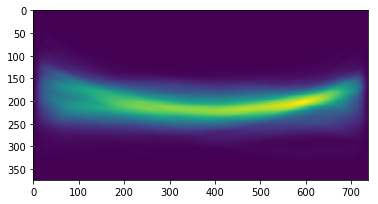

In [15]:
plt.imshow(np.mean(pad_imgs, (0,1)))
plt.show()

In [15]:
pad_imgs = pad_imgs[:,:,50:-50,:]
pad_imgs.shape

(1126, 61, 274, 738)

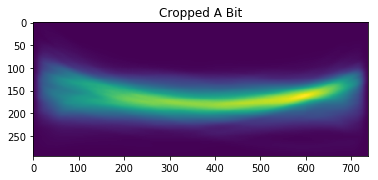

In [17]:
plt.title('Cropped A Bit')
plt.imshow(np.mean(pad_imgs, (0,1)))
plt.show()

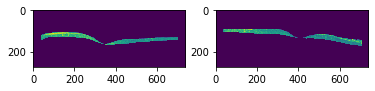

In [16]:
# before flipping
righties = [i for i in range(1126) if i not in lefties]
plt.subplot(121)
plt.imshow(pad_imgs[lefties[0],30])
plt.subplot(122)
plt.imshow(pad_imgs[righties[0],30])
plt.show()

In [16]:
# flip left images!
for ix, im in enumerate(pad_imgs):
    if ix in lefties:
        pad_imgs[ix] = np.flip(im, 2)

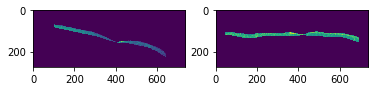

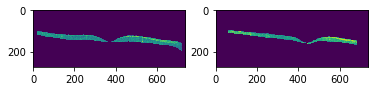

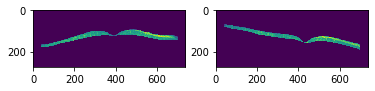

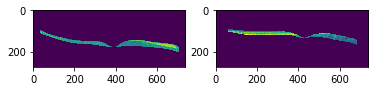

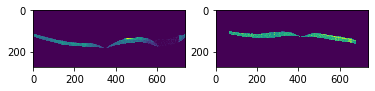

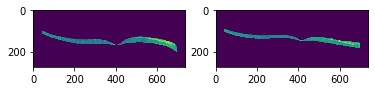

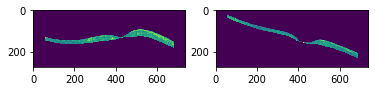

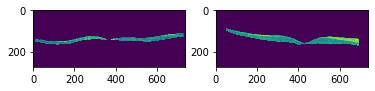

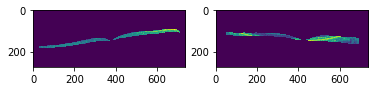

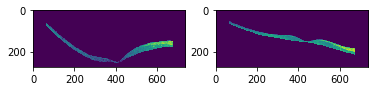

In [27]:
# after flipping
for i in range(10):
    plt.subplot(121)
    plt.imshow(pad_imgs[lefties[np.random.choice(np.arange(len(lefties)))],30])
    plt.subplot(122)
    plt.imshow(pad_imgs[righties[np.random.choice(np.arange(len(lefties)))],30])
    plt.show()

In [17]:
preixs = [np.arange(4,104, 10), np.arange(5,105, 10), np.arange(40,51,1), 
            np.arange(40,51,1), np.arange(50,60,1), 13, 23, 33, 22, 32, 31, 16, 26, 36, 27, 37, 38,
            61, 62, 72, 63, 73, 83, 86, 76, 66, 67, 77, 68, 12, 17, 82, 87, 21, 28, 71, 78]

circ_ixs = []
for i in preixs:
    if type(i)==np.ndarray:
        for j in i:
            circ_ixs.append(j)
    else:
        circ_ixs.append(i)
circ_ixs = np.array(circ_ixs)
circ_ixs = circ_ixs.astype(np.int32)
circ_ixs = list(set(circ_ixs))

In [ ]:
def check_data(pat_id, eye):
    """
    pat_id: ACPS020, AGPS001, e.t.c.
    eye: RE or LE
    """
    locs = ['L_'+str(i) for i in range(1,69)]
    pat_locs = np.array(vf.loc[(vf['PAT_ID']==pat_id) & (vf['EYE']==eye), locs])  # the index is already sorted by time
    ixs = vf.loc[(vf['PAT_ID']==pat_id) & (vf['EYE']==eye)].index
    ixs = [np.sum(vf.loc[vf['Used']==1, 'Used'][:ix]).astype(np.int32) for ix in ixs]
    return pat_locs, pad_imgs[ixs]

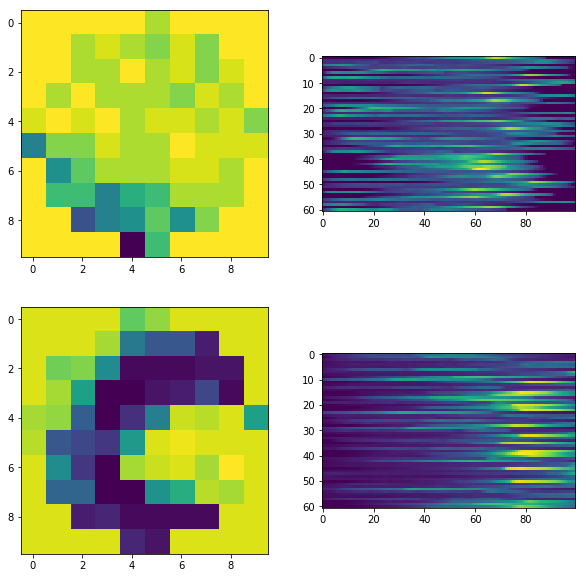

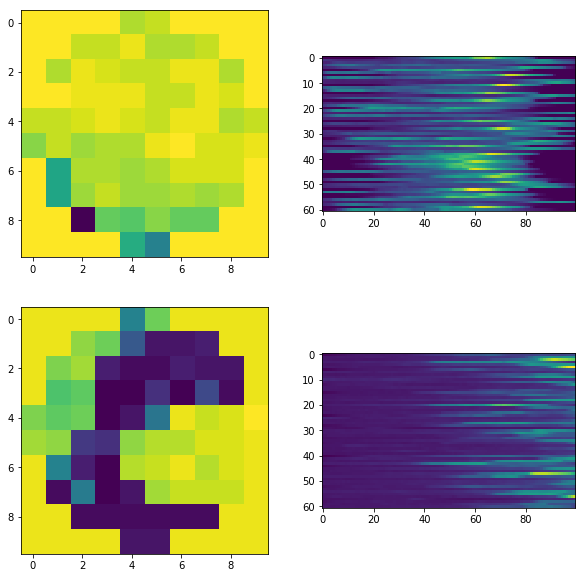

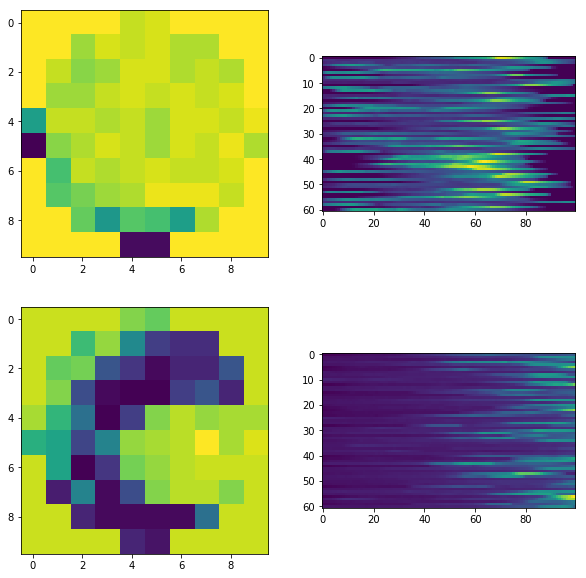

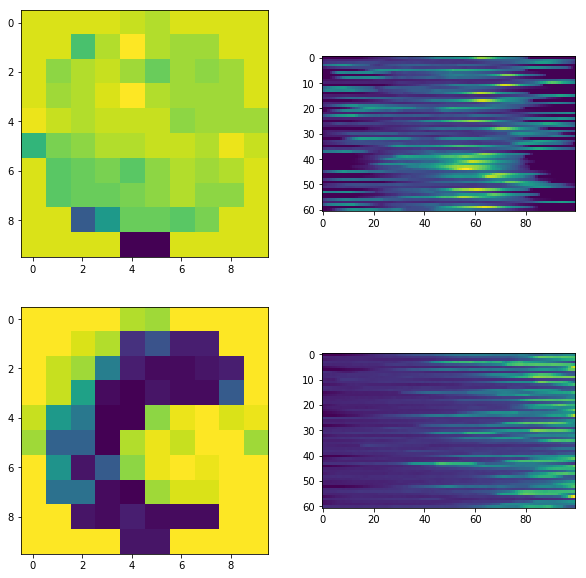

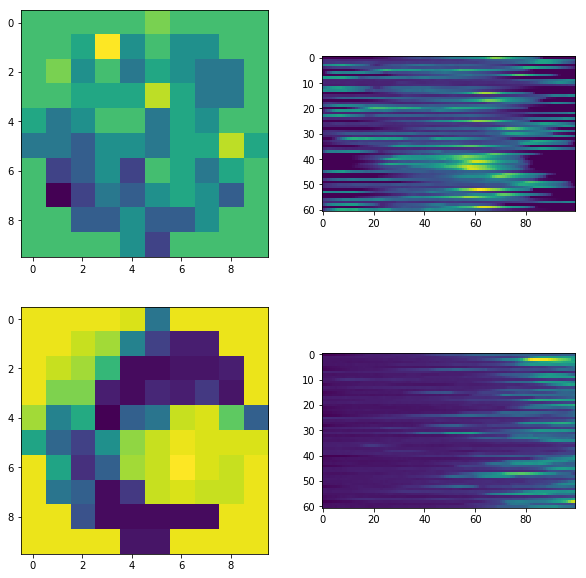

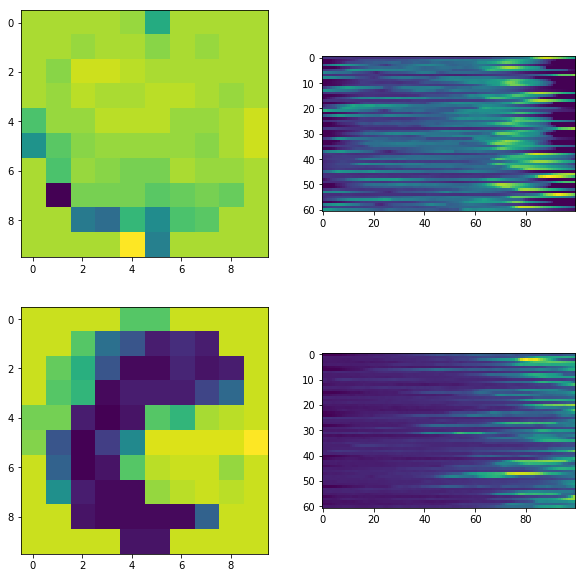

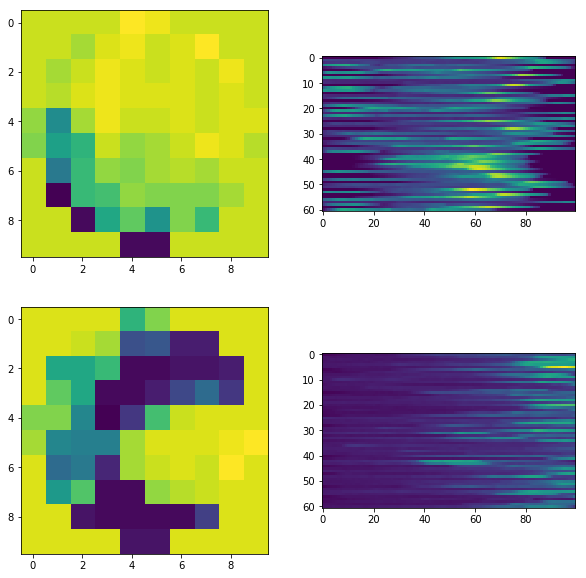

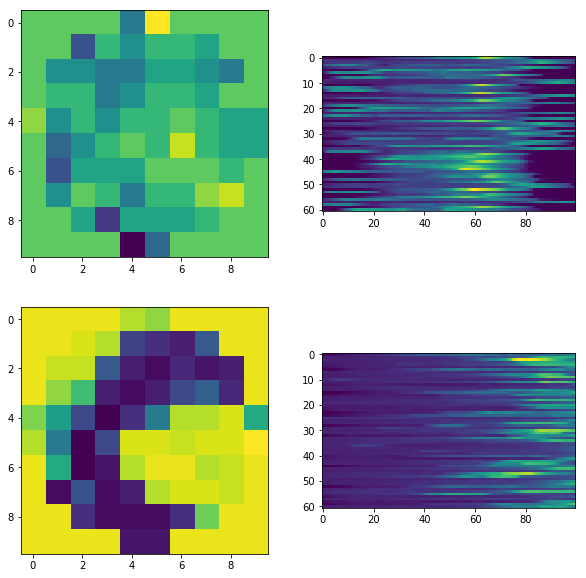

In [20]:
# check a bunch of patients input/output
pat1_vf, pat1_imgs = check_data('AGPS001', 'RE')
pat2_vf, pat2_imgs = check_data('AGPS020', 'RE')

for i in range(min(len(pat1_imgs), len(pat2_imgs))):
    circ_im1 = np.zeros(100)
    circ_im2 = np.zeros(100)
    circ_im1[circ_ixs] = pat1_vf[i]
    circ_im2[circ_ixs] = pat2_vf[i]
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(circ_im1.reshape(10,10))
    plt.subplot(222)
    plt.imshow(np.mean(pat1_imgs[i,:,100:200], -1))
    plt.subplot(223)
    plt.imshow(circ_im2.reshape(10,10))
    plt.subplot(224)
    plt.imshow(np.mean(pat2_imgs[i,:,100:200], -1))
    plt.show()

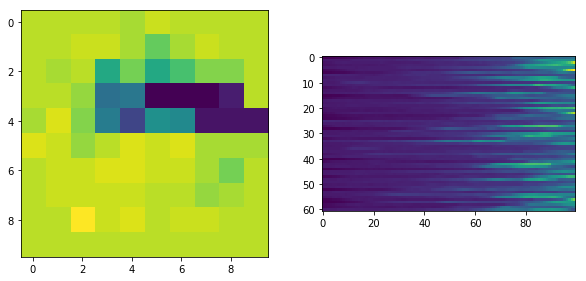

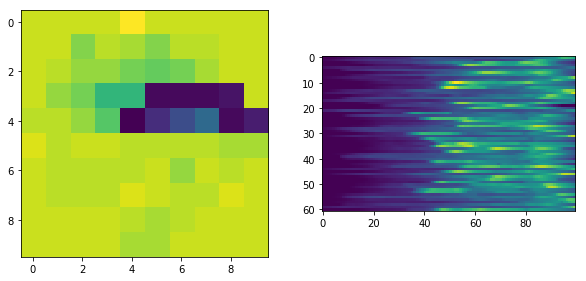

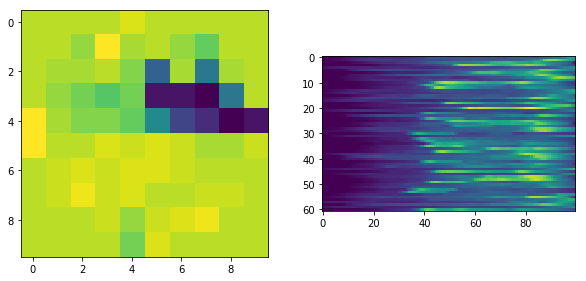

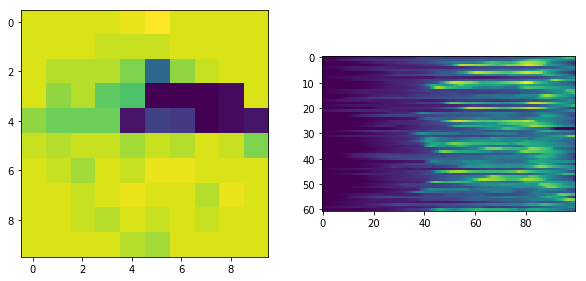

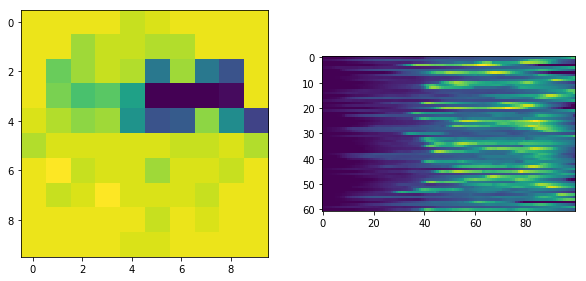

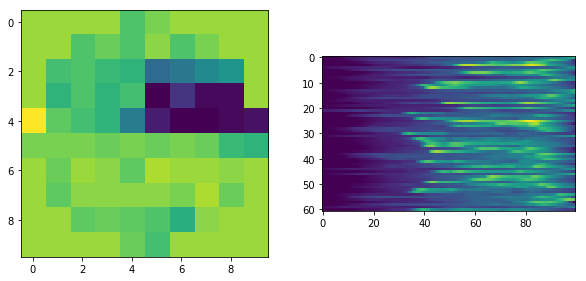

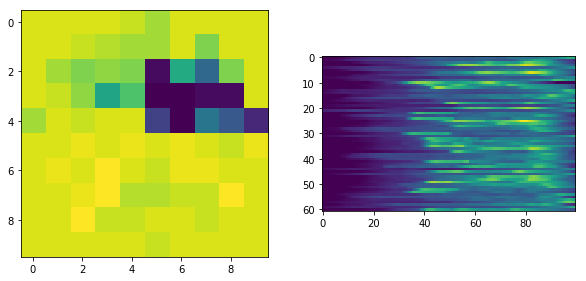

In [21]:
# check to make sure left flipping wasn't weird
pat3_vf, pat3_imgs = check_data('AGPS022', 'LE')

for i in range(len(pat3_imgs)):
    circ_im = np.zeros(100)
    circ_im[circ_ixs] = pat3_vf[i]
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(circ_im.reshape(10,10))
    plt.subplot(222)
    plt.imshow(np.mean(pat3_imgs[i,:,100:200], -1))

data looks good, I think the flipping worked it seems like everything is good. However, there are some problematic data points where it seems like an eye has been flipped or the vfs are flipped. These aren't my fault, it's in the data. Look at the vfs for 'RE' 'AGPS0001' vfs are a bit screwy.

In [36]:
def tfrecord_write_1D(record_pth, img, vf, lefty, rot=0.0):
    writer = tf.compat.v1.python_io.TFRecordWriter(record_pth + '.tfrecord')
    feature = {}
    feature['img'] = tf.train.Feature(float_list=tf.train.FloatList(value=img))
    feature['vf'] = tf.train.Feature(float_list=tf.train.FloatList(value=vf))
    feature['md'] = tf.train.Feature(float_list=tf.train.FloatList(value=[vf.mean()]))
    feature['lefty'] = tf.train.Feature(float_list=tf.train.FloatList(value=[lefty]))
    feature['rot'] = tf.train.Feature(float_list=tf.train.FloatList(value=[rot]))
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()
    writer.write(serialized)
    writer.close()

In [19]:
# DOUBLE CHECK BEFORE PRESENTING RESULTS, I THINK THIS WORKED BUT MAY NOT HAVE!
#keep_ix = np.array([keep_ix[i] for i in range(len(keep_ix)) if i not in bad_z_ixs])
#vf_locs = np.array(vf.iloc[keep_ix,5:])
locs = ['L_'+str(i) for i in range(1, 69)]
vf_used = vf.loc[(vf['Used']==1)]
vf_used.index = np.arange(0,len(vf_used),1)
vf_locs = vf.loc[(vf['Used']==1), locs]  # same shape and order as vf_used

vf_locs = np.array(vf_locs)
vf_locs.shape

(1126, 68)

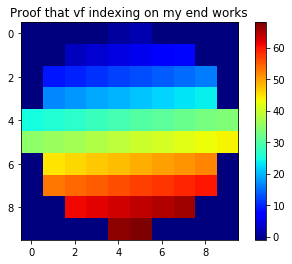

In [28]:
# define vf circle
test = np.zeros(100)-1
test[circ_ixs] = np.arange(1, 69, 1)

plt.title('Proof that vf indexing on my end works')
plt.imshow(test.reshape(10,10), cmap='jet') 
plt.colorbar()
plt.show()

In [20]:
vf_locs.shape, pad_imgs.shape  # done! pad_imgs is really 4D (n, 3D) and vf_locs is really 3D (n, 2D)

((1126, 68), (1126, 61, 274, 738))

In [21]:
from scipy.ndimage import rotate

In [39]:
def check_borders(img):
    borders = [img[:,:,0], img[:,0,:], img[:,-1,:]]
    for i, b in enumerate(borders):
        if (b > 0).any():
            return True
    return False

In [44]:
check_borders(rotate(pad_imgs[1100], angle=-10, axes=(2,1), reshape=False))

False

In [90]:
np.where(pad_imgs[1100,0]>0)

(array([ 94,  95,  95, ..., 204, 204, 204], dtype=int64),
 array([ 23,  23,  24, ..., 562, 563, 564], dtype=int64))

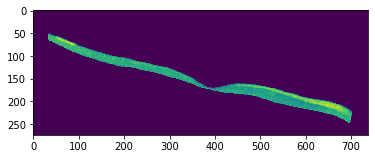

In [42]:
img = rotate(pad_imgs[1100], angle=-10, axes=(2,1), reshape=False)
plt.imshow(img[30])
plt.show()

In [32]:
import napari

In [33]:
pad_imgs.shape

(24, 61, 168, 738)

In [34]:
with napari.gui_qt():
    viewer = napari.view_image(pad_imgs[0])

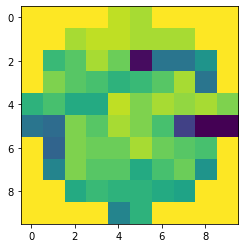

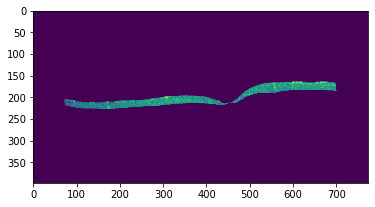

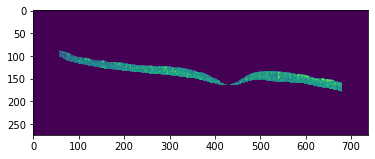

In [42]:
i = 100
test = np.zeros(100)-1
test[circ_ixs] = vf_locs[i]
plt.imshow(test.reshape(10,10))
plt.show()
img = rotate(pad_imgs[i], angle=10, axes=(2,1))

plt.imshow(img[30])
plt.show()
plt.imshow(pad_imgs[i,30])
plt.show()
#img[:,0,0] = 255
#img[:,-1,-1] = 255
#img[0,:,0] = 255
#img[-1,:,-1] = 255
#img[-1,-1,:] = 255
#img[0,0,:] = 255
#with napari.gui_qt():
#    viewer = napari.view_image(img)

In [85]:
with napari.gui_qt():
    viewer = napari.view_image(pad_imgs[1100])

In [ ]:
#Check data augmentation techniques
plt.imshow(pad_imgs)

In [33]:
pad_imgs = pad_imgs.reshape(pad_imgs.shape[0], -1)  # should be at least 1126
pad_imgs.shape

(1126, 12334932)

In [ ]:
np.save('data/full_vfs.npy', vf_locs), np.save('data/full_imgs.npy', pad_imgs)

In [ ]:
full_ixs = np.arange(0,len(vf_locs),1) 
train_ixs = np.random.choice(full_ixs, int(95*len(full_ixs)/100), replace=False)
test_ixs = [i for i in full_ixs if i not in train_ixs]
np.save('data/train_ixs.npy', train_ixs), np.save('data/test_ixs.npy', test_ixs)

In [38]:
for i in range(pad_imgs.shape[0]):
    tfrecord_write_1D('D://Evan/Bscan/full/'+str(i), pad_imgs[i].astype(np.float32), vf_locs[i].astype(np.float32))

In [ ]:
for i, record in enumerate(os.listdir('data/full/')):
    if not os.path.isdir('data/train/'+record):
        if i in train_ixs and not os.path.isfile('data/train/'+record):
            copyfile('data/full/'+record, 'data/train/'+record)
            print(i)
        elif i in test_ixs and not os.path.isfile('data/test/'+record):
            print(i)
            copyfile('data/full/'+record, 'data/test/'+record)
        else:
            pass

# split ixs by eye

In [30]:
vf_used['train'] = np.zeros(len(vf_used))
vf_used['test'] = np.zeros(len(vf_used))

C:\Users\fabien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\fabien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
full_patients = np.array(list(set(vf_used.PAT_ID)))
perm_ix = np.random.permutation(np.arange(0, len(full_patients), 1))
train_patients = full_patients[perm_ix[int(0.2*len(full_patients)):]]
test_patients = full_patients[perm_ix[:int(0.2*len(full_patients))]]
for i in vf_used.index:
    if vf_used.loc[i, 'PAT_ID'] in train_patients:
        vf_used.loc[i, 'train'] = 1
    if vf_used.loc[i, 'PAT_ID'] in test_patients:  # allows identification of duplicate train/test in case of accidents
        vf_used.loc[i, 'test'] = 1

C:\Users\fabien\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
vf_used.loc[vf_used.train==1].shape, vf_used.loc[vf_used.test==1].shape

((889, 76), (237, 76))

In [33]:
vf_used.to_csv('vf_used_split_by_patient_071120.csv')

In [34]:
train_ixs, test_ixs = np.array(vf_used.loc[vf_used.train==1].index), np.array(vf_used.loc[vf_used.test==1].index)

In [35]:
len([i for i in test_ixs if i in train_ixs])

0

In [58]:
def rot_and_check(img, angle):
    if angle!=0:
        rot_img = rotate(img, angle=angle, axes=(2,1), reshape=False)
        if not check_borders(rot_img):  # no intersection, proceed
            return rot_img
        elif check_borders(img):  # original intersected, proceed
            return rot_img
        elif not check_borders:  # original did not intersect, stop
            return np.array([False])
        else:
            return np.array([False])
    else:
        return img

In [55]:
import os

In [57]:
img

In [64]:
for i in range(pad_imgs.shape[0]):
    left = np.array([i in lefties])
    if i in train_ixs:
        for angle in [0,1,-1,2,-2,4]:
            fl_angle = np.array([angle]).astype(np.float32)
            img = rot_and_check(pad_imgs[i], angle)
            if img.dtype!='bool':
                tfrecord_write_1D('D://Evan/Bscan/train/'+str(i)+'_a'+str(angle), 
                                  img.flatten().astype(np.float32), 
                                  vf_locs[i].astype(np.float32),
                                  left[0].astype(np.float32),
                                  fl_angle[0])
    elif i in test_ixs:
        if not os.path.isfile('D://Evan/Bscan/test/'+str(i)+'.tfrecord'):
            tfrecord_write_1D('D://Evan/Bscan/test/'+str(i), 
                          pad_imgs[i].flatten().astype(np.float32), 
                          vf_locs[i].astype(np.float32),
                          left[0].astype(np.float32))

In [39]:
for i, record in enumerate(os.listdir('D://Evan/Bscan/full/')):
    if not os.path.isdir('D://Evan/Bscan/train/'+record):
        if i in train_ixs and not os.path.isfile('D://Evan/Bscan/train/'+record):
            copyfile('D://Evan/Bscan/full/'+record, 'D://Evan/Bscan/train/'+record)
            print(i)
        elif i in test_ixs and not os.path.isfile('D://Evan/Bscan/test/'+record):
            print(i)
            copyfile('D://Evan/Bscan/full/'+record, 'D://Evan/Bscan/test/'+record)
        else:
            pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# Old Split (More Files)

In [61]:
def get_images(pat_id, visit_date, eye):
    eye_dict = {'RE': '_OD', 'LE': '_OS', 'OS': '_OS', 'OD': '_OD'}
    dir_name = False
    for img_path in img_paths:
        if eye in list(eye_dict.keys()):
            if os.path.isdir(img_path+'/'+pat_id+eye_dict[eye]+'/'+visit_date):
                dir_name = img_path+'/'+pat_id+eye_dict[eye]+'/'+visit_date
                break
            elif os.path.isdir(img_path+'/'+pat_id+'_'+eye+'/'+visit_date):
                dir_name = img_path+'/'+pat_id+'_'+eye+'/'+visit_date
                break
        elif os.path.isdir(img_path+'/'+pat_id+'_'+eye+'/'+visit_date):
            dir_name = img_path+'/'+pat_id+'_'+eye+'/'+visit_date
            break
    if dir_name:
        if 'LE' in eye or 'OS' in eye:  # must be flipped for left eyes so that the model doesn't learn this distinction
            images = np.array([np.array(Image.open(dir_name+'/'+im))[:,:,0] for im in os.listdir(dir_name)])  # its rgba but r=g=b
            images = np.flip(images, axis=images.shape.index(np.max(images.shape)))  # flip along the longest axis
        else:
            images = np.array([np.array(Image.open(dir_name+'/'+im))[:,:,0] for im in os.listdir(dir_name)])  # its rgba but r=g=b
        return images, img_path+'/'+pat_id+eye_dict[eye]+'/'  
    else:
        bad_files.append(i)
        return False, False

In [2]:
vf_used = pd.read_csv('D://Evan/Bscan/first_processing/vf_used_split_by_patient.csv')
train_ixs, test_ixs = np.array(vf_used.loc[vf_used.train==1].index), np.array(vf_used.loc[vf_used.test==1].index)

In [7]:
full_imgs = np.load('D://Evan/Bscan/first_processing/full_imgs.npy')

ValueError: cannot reshape array of size 5713965687 into shape (1005,13235292)

In [5]:
full_imgs = np.load('D://Evan/Bscan/first_processing/full_imgs.npy', mmap_mode='r')
full_vfs = np.load('D://Evan/Bscan/first_processing/full_vfs.npy')
full_imgs.shape, full_vfs.shape

OSError: [WinError 8] Not enough memory resources are available to process this command

In [ ]:
np.save()

# Checking things later

In [3]:
vf_locs, pad_imgs = np.load('data/full_vfs.npy'), np.load('data/full_imgs.npy')

In [ ]:
plt.hist(np.log(vf_locs.flatten()+37), bins=56)
plt.show()

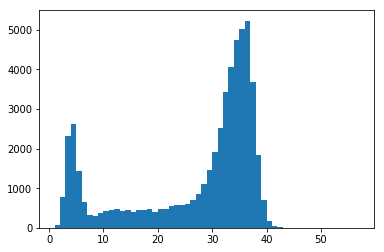

In [20]:
plt.hist(vf_locs.flatten()+37, bins=56)
plt.show()

In [21]:
np.mean(vf_locs, 1).shape

(795,)

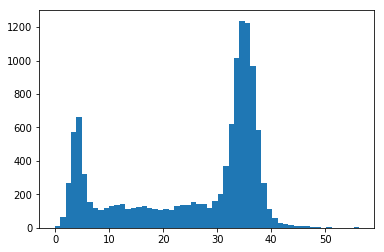

In [60]:
fit_by_eye = np.concatenate([np.random.normal(35, 2, 6000), 
                             np.random.normal(4, 1.1, 1750),
                             np.abs(np.random.normal(25, 9, 3000)),
                             np.abs(np.random.normal(10, 4, 1000))])
plt.hist(fit_by_eye, bins=56)
plt.show()

In [12]:
0.61**2

0.3721

In [29]:
!rm -rf ~/.local/share/Trash/*